# Solving 2d electrostatics problem numerically

Let's solve electrostatics problem

$$ \nabla^2 \phi = \frac{\rho}{\epsilon_0} $$

with given source charge distribution and boundary conditions.

The poisson's equation can be expressed more explicitly, i.e.,

$$ (\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}) \phi (x,y) = \frac{\rho (x,y)}{\epsilon_0} $$

Discretizing the partial differential operators, we have

$$ \frac{\partial \phi}{\partial x} = \frac{\phi (x+h, y) - \phi (x, y)}{h} $$

$$ \frac{\partial^2 \phi}{\partial x^2} = \frac{\phi(x+h,y) - 2\phi(x,y) + \phi(x-h,y)}{h^2} $$

with some discretizing factor $h$.

Now we have difference equation:

$$ \frac{\phi(x+h,y) - 2\phi(x,y) + \phi(x-h,y)}{h^2} + \frac{\phi(x,y+h) - 2\phi(x,y) + \phi(x,y-h)}{h^2} 
    = \frac{\rho(x,y)}{\epsilon_0} $$
    
Since the space is discretized, we can represent the potential as a matrix $\phi(x,y) = \phi_{i,j}$. Here, the difference of coordinates between any neighboring elements is $h$. The source term is also changed to $\rho(x,y) = \rho_{i.j}$. Then the difference equation is transformed into

$$ \frac{\phi_{i+1,j} + \phi_{i-1,j} + \phi_{i,j+1} + \phi_{i,j-1} - 4\phi_{i,j}}{h^2} = 
    \frac{\rho_{i,j}}{\epsilon_0} $$
    
Here, the subscripts are $ 2 \leq i \leq N-1 $ and $ 2 \leq j \leq M-1 $.

The difference equation can be formulated in 2 ways. One is direct method using matrix, and the other is interative method using stencil operation. Let's do matrix version first.


## Direct method

Consequently, the equation is converted into matrix equation:

$$ \begin{bmatrix}
      D    &   -I   &    0   & \cdots &    0   &    0   \\
     -I    &    D   &   -I   & \cdots &    0   &    0   \\
      0    &   -I   &    D   & \cdots &    0   &    0   \\
    \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
      0    &    0   &    0   & \cdots &    D   &   -I   \\
      0    &    0   &    0   & \cdots &   -I   &    D
    \end{bmatrix}
    \begin{bmatrix}
    \phi_{2,2} \\
    \phi_{3,2} \\
    \vdots     \\
    \phi_{N-1,2} \\
    \phi_{2,3} \\
    \phi_{3,3} \\
    \vdots     \\
    \phi_{N-1,3} \\
    \phi_{2,M-1} \\
    \phi_{3,M-1} \\
    \vdots     \\
    \phi_{N-1,M-1}
    \end{bmatrix}
    =
    \begin{bmatrix}
    -\frac{h^2}{\epsilon_0}\rho_{2,2} + \phi_{1,2} + \phi_{2,1} \\
    -\frac{h^2}{\epsilon_0}\rho_{3,2} + \phi_{3,1} \\
    \vdots     \\
    -\frac{h^2}{\epsilon_0}\rho_{N-1,2} + \phi_{N,2} + \phi_{N-1,1} \\
    -\frac{h^2}{\epsilon_0}\rho_{2,3} + \phi_{1,3} \\
    -\frac{h^2}{\epsilon_0}\rho_{3,3} \\
    \vdots     \\
    -\frac{h^2}{\epsilon_0}\rho_{N-1,3} + \phi_{N,3} \\
    -\frac{h^2}{\epsilon_0}\rho_{2,M-1} + \phi_{1,M-1} + \phi_{2,M} \\
    -\frac{h^2}{\epsilon_0}\rho_{3,M-1} + \phi_{3,M} \\
    \vdots     \\
    -\frac{h^2}{\epsilon_0}\rho_{N-1,M-1} + \phi_{N,M-1} + \phi_{N-1,M}
    \end{bmatrix}
    $$

where $I$ is $(N-2) \times (N-2)$ identity matrix and $D$ is $(N-2) \times (N-2)$ matrix, given by

$$ D = \begin{bmatrix}
        4  &  -1  &  0  &  0  & \cdots &  0  \\
       -1  &   4  & -1  &  0  & \cdots &  0  \\
        0  &  -1  &  4  & -1  & \cdots &  0  \\
        \vdots  &  \vdots  &  \vdots  &  \vdots  & \ddots &  -1  \\
        0  &  0  &  0  &  0  &  -1  &  4
        \end{bmatrix}
$$

Also note that the boundary elements are brought to right-hand side. 

In [10]:
L = 1
h = 0.05
n = Int(L/h)
nbound = n+2
D = SymTridiagonal(repmat([4], n), repmat([-1], n))

20×20 SymTridiagonal{Int64}:
  4  -1   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅  …   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
 -1   4  -1   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅  -1   4  -1   ⋅   ⋅   ⋅   ⋅   ⋅      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅  -1   4  -1   ⋅   ⋅   ⋅   ⋅      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅  -1   4  -1   ⋅   ⋅   ⋅      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅  -1   4  -1   ⋅   ⋅  …   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅  -1   4  -1   ⋅      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅  -1   4  -1      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅  -1   4      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅  -1      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅  …  -1   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅      4  -1   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅     -1   4  -1   ⋅   ⋅   ⋅   ⋅   ⋅ 

In [11]:
coeff = spzeros(n^2, n^2)

400×400 SparseMatrixCSC{Float64,Int64} with 0 stored entries

In [12]:
for j in 1:n
    view(coeff, (j-1)*n+1 : j*n, (j-1)*n+1 : j*n) .= D
end
for j in 1:n-1
    view(coeff, j*n+1 : (j+1)*n, (j-1)*n+1 : j*n) .= -eye(n,n)
    view(coeff, (j-1)*n+1 : j*n, j*n+1 : (j+1)*n) .= -eye(n,n)
end        

In [13]:
writedlm("coeff matrix.csv", coeff, ',')

In [14]:
source = zeros(n^2)
boundary_cond = zeros(n, n) 
# boundary condition: V=1 for x-direction and V=0 for y-direction.
boundary_cond[:, 1] .+= 0
boundary_cond[:, end] .+= 0
boundary_cond[1, :] .+= 1
boundary_cond[end, :] .+= 1
boundary_cond = vec(boundary_cond)
sourceterm = source .+ boundary_cond

400-element Array{Float64,1}:
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0

In [16]:
potential = coeff\sourceterm
potential2d = zeros(n, n)
potential2d .= reshape(potential, n, n)
writedlm("potential.csv", potential2d, ',')
potential2d


20×20 Array{Float64,2}:
 0.5        0.697559  0.790237  0.840568  …  0.790237  0.697559  0.5      
 0.302441   0.5       0.622819  0.701038     0.622819  0.5       0.302441 
 0.209763   0.377181  0.5       0.588016     0.5       0.377181  0.209763 
 0.159432   0.298962  0.411984  0.5          0.411984  0.298962  0.159432 
 0.129      0.247252  0.348972  0.432852     0.348972  0.247252  0.129    
 0.109318   0.212075  0.303801  0.382435  …  0.303801  0.212075  0.109318 
 0.0961956  0.187928  0.271723  0.345447     0.271723  0.187928  0.0961956
 0.0875368  0.171718  0.249717  0.319505     0.249717  0.171718  0.0875368
 0.0822336  0.16169   0.235921  0.303011     0.235921  0.16169   0.0822336
 0.0797074  0.156888  0.229267  0.294993     0.229267  0.156888  0.0797074
 0.0797074  0.156888  0.229267  0.294993  …  0.229267  0.156888  0.0797074
 0.0822336  0.16169   0.235921  0.303011     0.235921  0.16169   0.0822336
 0.0875368  0.171718  0.249717  0.319505     0.249717  0.171718  0.0875368
 

In [17]:
using Plots
pyplot()

Plots.PyPlotBackend()


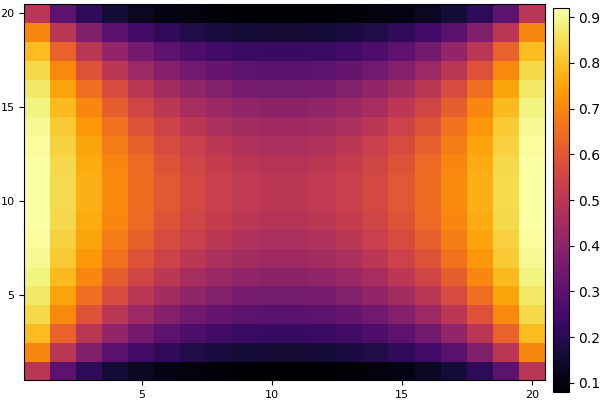

In [18]:
heatmap(potential2d')

## Iterative version

From the difference equation:

$$ \frac{\phi_{i+1,j} + \phi_{i-1,j} + \phi_{i,j+1} + \phi_{i,j-1} - 4\phi_{i,j}}{h^2} = 
    \frac{\rho_{i,j}}{\epsilon_0} $$

The iterative solution proceeds from initial guess $\phi_{i,j}^{(0)}$ and iterates until convergence using

$$ \phi_{i,j}^{(n+1)} = \frac{\phi_{i+1,j}^{(n)} + \phi_{i-1,j}^{(n)} + \phi_{i,j+1}^{(n)} + \phi_{i,j-1}^{(n)} - h^2 \frac{\rho_{i,j}} {\epsilon_0}}{4} $$

This iteration is called Jacobi iteration.

In [19]:
h = 0.05
L = 1
n = Int(L/h)

20

In [46]:
potential2d_iter = zeros(n+2,n+2)
potential2d_iter[1,:] = 1
potential2d_iter[end,:] = 1
potential2d_iter

22×22 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

In [47]:
maxiter = 10000
tol = 1e-9
sourceterm = 0.0
temp = copy(potential2d_iter)
for k in 1:maxiter
    for j in 2:n+1, i in 2:n+1
        temp[i,j] = 0.25*(potential2d_iter[i+1,j] + potential2d_iter[i-1,j] + potential2d_iter[i,j+1] + potential2d_iter[i,j-1] - sourceterm)
    end
    tolnow = norm(temp .- potential2d_iter)
    copy!(potential2d_iter, temp)
    tolnow <= tol && (@show(k); break)
end
potential2d_iter

1637


22×22 Array{Float64,2}:
 1.0  1.0        1.0       1.0       …  1.0       1.0       1.0        1.0
 0.0  0.5        0.697559  0.790237     0.790237  0.697559  0.5        0.0
 0.0  0.302441   0.5       0.622819     0.622819  0.5       0.302441   0.0
 0.0  0.209763   0.377181  0.5          0.5       0.377181  0.209763   0.0
 0.0  0.159432   0.298962  0.411984     0.411984  0.298962  0.159432   0.0
 0.0  0.129      0.247252  0.348972  …  0.348972  0.247252  0.129      0.0
 0.0  0.109318   0.212075  0.303801     0.303801  0.212075  0.109318   0.0
 0.0  0.0961956  0.187928  0.271723     0.271723  0.187928  0.0961956  0.0
 0.0  0.0875368  0.171718  0.249717     0.249717  0.171718  0.0875368  0.0
 0.0  0.0822336  0.16169   0.235921     0.235921  0.16169   0.0822336  0.0
 0.0  0.0797073  0.156888  0.229267  …  0.229267  0.156888  0.0797073  0.0
 0.0  0.0797073  0.156888  0.229267     0.229267  0.156888  0.0797073  0.0
 0.0  0.0822336  0.16169   0.235921     0.235921  0.16169   0.0822336  0.0
 


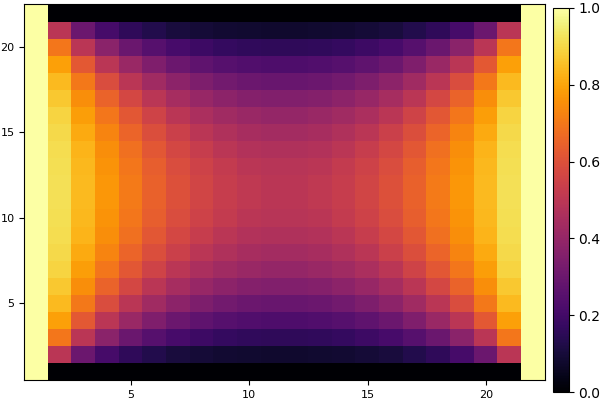

In [48]:
heatmap(potential2d_iter')

Julia has an `IterativeSolvers.jl` package which has the Jacobi solver. But it looks like that it solves $Ax=b$ iteratively.

## Adding boundaries inside the problem domain

Let's try to solve the Poisson equation when there is a metal circle at the center of the domain. The metal is conntected to ($V=2$) and the radius of the circle is $r=0.1$.

In [53]:
potential2d_iter = zeros(n+2,n+2)
potential2d_iter[1,:] = 1
potential2d_iter[end,:] = 1
potential2d_iter

22×22 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

In [65]:
maxiter = 10000
tol = 1e-9
sourceterm = 0.0
domaincenter=n/2 + 1
circlecenter = round(Int, n/2) + 1
circleup = circlecenter + 2
circlelow = circlecenter - 2
temp = copy(potential2d_iter)
for k in 1:maxiter
    for j in 2:n+1, i in 2:n+1
        temp[i,j] = 0.25*(potential2d_iter[i+1,j] + potential2d_iter[i-1,j] + potential2d_iter[i,j+1] + potential2d_iter[i,j-1] - sourceterm)
    end
    # enforce B.C
    temp[circlecenter, circlelow] = 2.0
    temp[circlecenter-1:circlecenter+1, circlecenter-1] = 2.0
    temp[circlelow:circleup, circlecenter] = 2.0
    temp[circlecenter-1:circlecenter+1, circlecenter+1] = 2.0
    temp[circlecenter, circleup] = 2.0
    tolnow = norm(temp .- potential2d_iter)
    copy!(potential2d_iter, temp)
    tolnow <= tol && (@show(k); break)
end
potential2d_iter

k = 619


22×22 Array{Float64,2}:
 1.0  1.0       1.0       1.0       …  1.0       1.0       1.0       1.0
 0.0  0.514249  0.72605   0.832907     0.82764   0.722404  0.512389  0.0
 0.0  0.330946  0.557042  0.708366     0.697556  0.549587  0.327151  0.0
 0.0  0.252495  0.462805  0.628701     0.611827  0.451239  0.246626  0.0
 0.0  0.216228  0.412982  0.58391      0.560271  0.396915  0.208116  0.0
 0.0  0.199435  0.388986  0.563552  …  0.532398  0.368034  0.188922  0.0
 0.0  0.192528  0.379974  0.559209     0.519959  0.353903  0.179537  0.0
 0.0  0.190702  0.379173  0.564148     0.516709  0.34808   0.175325  0.0
 0.0  0.191106  0.381869  0.572637     0.517794  0.346385  0.173681  0.0
 0.0  0.191854  0.384559  0.57967      0.519443  0.345987  0.173012  0.0
 0.0  0.191752  0.384842  0.581351  …  0.519046  0.345107  0.172381  0.0
 0.0  0.19031   0.381707  0.575907     0.5155    0.343012  0.171405  0.0
 0.0  0.187782  0.375769  0.56466      0.509455  0.340036  0.170229  0.0
 0.0  0.185049  0.368927  0


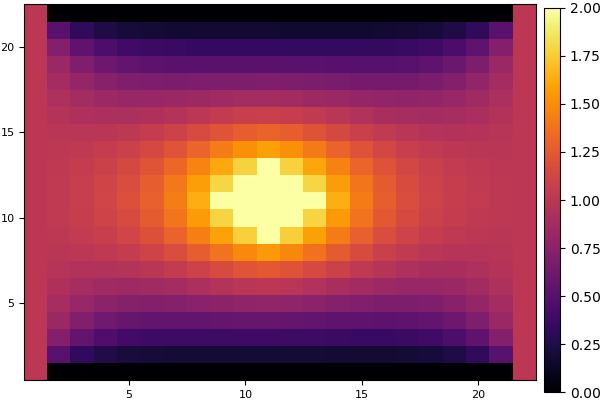

In [66]:
heatmap(potential2d_iter')


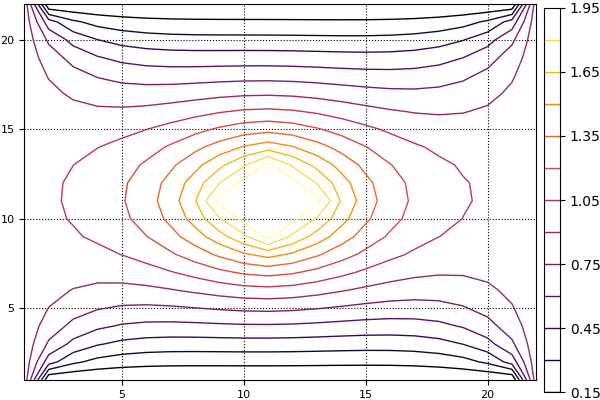

In [68]:
contour(potential2d_iter')